In [53]:
import numpy as np
import numpy.random as random

import matplotlib.pyplot as plt
from typing import List
%matplotlib inline

# Part 2

In [54]:
distance_matrix: List[List[float]] = []

class City:

    def __init__(self, index: int, x: float, y: float):
        self.index = index
        self.x = x
        self.y = y

    def compute_distance(self, city: "City"):
        return np.sqrt((self.x - city.x)**2 + (self.y - city.y)**2)

    def __str__(self):
        return '%d %f %f' % (self.index, self.x, self.y)

    def __repr__(self):
        return self.__str__()

    def distance_to_city(self, city: "City"):
        """Distance to another city using pre-computed distance."""
        global distance_matrix
        if self.index != city.index:
            indices = [self.index, city.index]
            return distance_matrix[max(indices)][min(indices)]
        return 0

In [55]:
def compute_distance_pair(cities: List[City], out: List[List[float]]):
    for city_from in cities:
        out.append([0 for r in range(city_from.index)])
        for city_to in cities[:city_from.index]:
            out[city_from.index][city_to.index] = city_from.compute_distance(city_to)

In [56]:
def read_cities(filename: str):
    with open(filename, 'r') as f:
        rows = [line.split() for line in f]
        cities = [City(index, float(coord[0]), float(coord[1])) for index, coord in enumerate(rows)]
        return cities

In [57]:
def total_distance(cities: List[City]):
    distances = [cities[index].distance_to_city(cities[(index + 1) % len(cities)]) for index in range(len(cities))]
    return sum(distances)

In [58]:
cities = read_cities("towns.txt")

In [59]:
compute_distance_pair(cities, distance_matrix)

In [60]:
distance_matrix

[[],
 [144.81022063376605],
 [114.93476410555685, 144.22205101855957],
 [105.4229576515476, 181.91206666958627, 49.678969393496885],
 [31.89043743820395, 147.61097520171052, 86.33075929238663, 73.60027173862879],
 [109.73149046650191,
  76.79192665899195,
  169.26015479137433,
  189.39112967612817,
  128.76334882255898],
 [135.94851966829208,
  195.02820308868152,
  51.419840528729765,
  31.622776601683793,
  104.06248123122954,
  212.5111761766896],
 [132.83448347473634,
  73.76313442364011,
  78.18567643756751,
  124.02015965156633,
  119.23086848631104,
  126.25371281669304,
  129.34063553268942],
 [85.80209787645055,
  64.62197768561404,
  130.78226179417453,
  152.64337522473747,
  97.71898484941399,
  38.48376280978771,
  174.64249196572982,
  92.78469701410896],
 [79.83107164506812,
  114.84337159801605,
  42.20189569201838,
  67.26812023536856,
  57.42821606144492,
  128.41339493993607,
  85.0,
  65.80273550544841,
  90.13878188659973],
 [158.00316452527144,
  220.6558406206371

In [61]:
def plot_cities(cities: List[City], figure_id: int):
    fig_map = plt.figure(figure_id)
    ax_map = fig_map.add_subplot(111)

    cities_x = [city.x for city in cities + [cities[0]]]
    cities_y = [city.y for city in cities + [cities[0]]]
    ax_map.plot(cities_x, cities_y, 'go-')
    ax_map.grid()

    return fig_map, ax_map

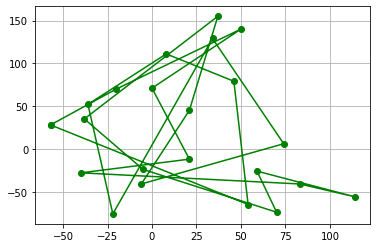

In [62]:
fig_map, ax_map = plot_cities(cities, 1)

In [63]:
total_distance(cities)

2135.1340542880625

In [64]:
def compute_path_indeces(index: int, num_of_cities: int):
    index_previous = (index - 1) % num_of_cities
    index_next = (index + 1) % num_of_cities
    return (index_previous, index_next)

In [65]:
def distance_swap(cities: List[City], index_a: int, index_B: int):
    """
    Compute the distance inferred by the two given indices.
    Used to optimize computation of total distances
    """

    index_A = min(index_a, index_B)
    index_B = max(index_a, index_B)

    (index_a_previous, index_a_next) = compute_path_indeces(index_A, len(cities))
    (index_b_previous, index_b_next) = compute_path_indeces(index_B, len(cities))

    distances: List[float] = []

    distances.append(cities[index_a_previous].distance_to_city(cities[index_A]))
    distances.append(cities[index_B].distance_to_city(cities[index_b_next]))

    # two cases of swaping indeces
    if index_A == index_b_previous:
        # --a_previous--a--b--b_next-- -> --a_previous--b--a--b_next-- 
        distances.append(cities[index_A].distance_to_city(cities[index_B]))
    else:
        #--a_previous--a--a_next ... b_previous-b--b_next -> --a_previous--b--a_next ... b_previous-a--b_next 
        distances.append(cities[index_A].distance_to_city(cities[index_a_next]))
        distances.append(cities[index_b_previous].distance_to_city(cities[index_B]))
        
    return sum(distances)

In [66]:
def annealing(cities: List[City], temperature: float = 100, temperature_end: float = 1, cooling_factor: float=.99):
    cities_best = cities[:]
    distance_best = total_distance(cities_best)
    print(distance_best)

    cities_new = cities_best[:]
    cities_current = cities_best[:]

    distance_new = distance_best
    distance_current = distance_best

    step = 0
    while temperature > temperature_end:
        #choose indexes to swap random
        index_0: int = random.randint(low=1, high=len(cities))
        index_1: int = random.randint(low=1, high=len(cities))

        swap_before = distance_swap(cities_new, index_0, index_1)
        cities_new[index_0], cities_new[index_1] = cities_new[index_1], cities_new[index_0]
        swap_after = distance_swap(cities_new, index_0, index_1)
        
        # distance_new = distance_new - swap_before + swap_after
        distance_new = total_distance(cities_new)
        # print(distance_new)
        diff = distance_new - distance_current

        if diff < 0 or  np.exp( -diff / temperature ) > random.random():
            cities_current = cities_new[:]
            distance_current = distance_new
        else:
            distance_new = distance_current
            cities_new = cities_current[:]

        if distance_current < distance_best:
            cities_best = cities_current[:]
            distance_best = distance_current

        temperature = temperature * cooling_factor
        step = step + 1
    
    return cities_best, distance_best, step


In [67]:
cities_best, distance_best, steps = annealing(cities, temperature=1e3, cooling_factor=0.999)

2135.1340542880625


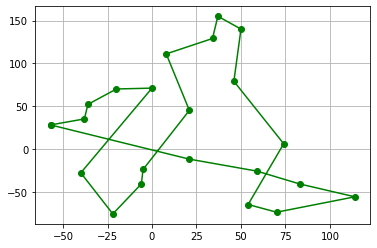

In [68]:
fig_map, ax_map = plot_cities(cities_best, 1)

In [69]:
total_distance(cities_best)

983.5478307522807